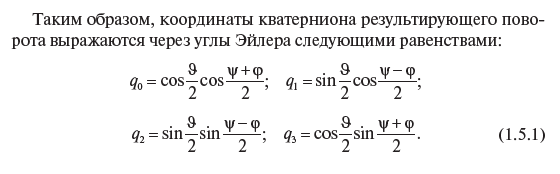

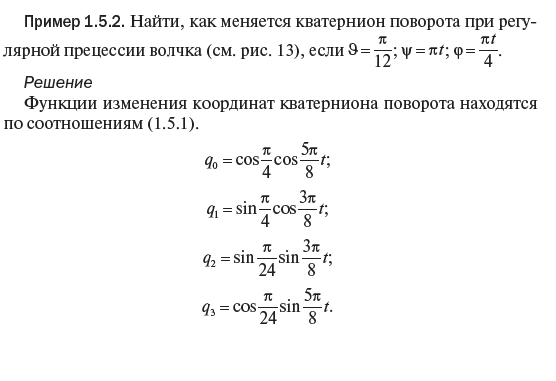

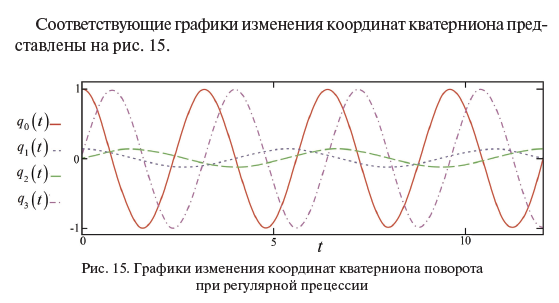

In [1]:
import numpy as np
from easyvec import Vec3, Mat3
import matplotlib.pyplot as plt

In [2]:
class Volchok(object):
    
    def __init__(self, **kwargs):
        
        nut, psi, phi = kwargs['nut'], kwargs['psi'], kwargs['phi'] # начальные углы
        
        self.w_psi = kwargs['w_psi'] # угловая скорость прецессии
        self.w_phi = kwargs['w_phi'] # угловая скорость собственного вращения
        self.state = self.get_init_quaternion(nut, psi, phi)
        self.t = 0
        self.n = len(self.state)
        self.history = {
            'qw': [],
            'qx': [],
            'qy': [],
            'qz': [],
            't': []
        }
    
    @property
    def nut(self):
        return np.pi/12 * (1 - np.exp(-self.t**2))
    
    @property
    def dir_nut(self):
        return np.pi/6 * self.t * np.exp(-self.t**2) 
    
    @property
    def quaternion(self):
        return np.array([self.qw, self.qx, self.qy, self.qz])
    
    @property
    def qw(self):
        return self.state[0]
    
    @property
    def qx(self):
        return self.state[1]
    
    @property
    def qy(self):
        return self.state[2]
    
    @property
    def qz(self):
        return self.state[3]
    
    @property
    def w(self):
        return np.array([self.wx, self.wy, self.wz])
    
    @property
    def wx(self):
        return (self.w_psi * np.sin(self.nut) * np.sin(self.w_phi * self.t) +\
                self.dir_nut * np.cos(self.w_phi * self.t))
    
    @property
    def wy(self):
        return (self.w_psi * np.sin(self.nut) * np.cos(self.w_phi * self.t) -\
                self.dir_nut * np.cos(self.w_phi * self.t))
    
    @property
    def wz(self):
        return self.w_phi + self.w_psi * np.cos(self.nut)
    
    def f_system(self, t, Y):

        qw, qx, qy, qz = Y       
        
        self.state = Y
        self.t = t
        wx, wy, wz = self.w
        
        dY = np.zeros(self.n)
        dY[0] = -1/2 * (qx * wx + qy * wy + qz * wz) 
        dY[1] = 1/2 * (qw * wx - qz * wy + qy * wz)
        dY[2] = 1/2 * (qw * wy - qx * wz + qz * wx)
        dY[3] = 1/2 * (qw * wz - qy * wx + qx * wy)

        return dY
       
    def step(self, tau=0.1, n=10):

        y = self.state
        t = self.t
        
        t_end = t + tau
        dt = tau / n
        
        flag = True
        while flag:
            
            if t_end - t > dt:
                dt = dt 
            
            else:
                dt = t_end - t
                flag = False
                
            k1 = self.f_system(t, y)
            k2 = self.f_system(t + 0.5 * dt, y + 0.5 * dt * k1)
            k3 = self.f_system(t + 0.5 * dt, y + 0.5 * dt * k2)
            k4 = self.f_system(t + dt,       y + dt * k3)
            y  = y + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
            
            t += dt
            self.t = t
            self.state = y
            
            self.history['qw'].append(y[0])
            self.history['qx'].append(y[1])
            self.history['qy'].append(y[2])
            self.history['qz'].append(y[3])
            self.history['t'].append(t)
            
    def get_init_quaternion(self, nut, psi, phi):
        qw = np.cos(nut/2) * np.cos((psi+phi)/2)
        qx = np.sin(nut/2) * np.cos((psi-phi)/2)
        qy = np.sin(nut/2) * np.sin((psi-phi)/2)
        qz = np.cos(nut/2) * np.sin((psi+phi)/2)
        return np.array([qw, qx, qy, qz])    

In [21]:
walk = Volchok(w_psi=np.pi, w_phi=np.pi/4, nut=0, psi=0, phi=0)

In [22]:
while walk.t < 15:
    walk.step()

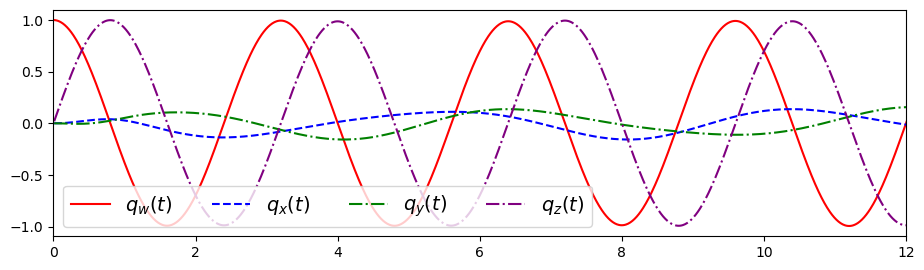

In [23]:
plt.figure(figsize=(11,3), dpi=100)
plt.plot(walk.history['t'], walk.history['qw'], label='$q_{w}(t)$', color='red')
plt.plot(walk.history['t'], walk.history['qx'], label='$q_{x}(t)$', color='blue', linestyle='--')
plt.plot(walk.history['t'], walk.history['qy'], label='$q_{y}(t)$', color='green', linestyle='-.')
plt.plot(walk.history['t'], walk.history['qz'], label='$q_{z}(t)$', color='purple', linestyle='-.')
plt.legend(fontsize=14, ncol=4)
plt.xlim(0,12)
plt.show()

In [6]:
qw, qx, qy, qz = 0.5, -0.5, -0.5, -0.5

In [8]:
qw, qx, qy, qz = 0.5, 0.5, 0.5, 0.5

In [9]:
C11 = 2 * (qw**2 + qx**2) - 1
C12 = 2 * (qx * qy - qw * qz)
C13 = 2 * (qx * qz + qw * qy)
C21 = 2 * (qx * qy + qw * qz)
C22 = 2 * (qw**2 + qy**2) - 1
C23 = 2 * (qy * qz - qw * qx)
C31 = 2 * (qx * qz - qw * qy)
C32 = 2 * (qy * qz + qw * qx)
C33 = 2 * (qw**2 + qz**2) - 1
        
C1 = Vec3(C11, C12, C13)
C2 = Vec3(C21, C22, C23)
C3 = Vec3(C31, C32, C33)
        
Mat3(*C1, *C2, *C3)

Mat3(0.000  , 0.000  , 1.000  , 
     1.000  , 0.000  , 0.000  ,
     0.000  , 1.000  , 0.000  )